In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
random_state = 123

def load_excel_sheets(file_path):
    '''Load all sheets from an Excel file and return a dictionary of DataFrames.'''
    xls = pd.ExcelFile(file_path)
    sheet_names = xls.sheet_names
    dfs = {}
    for sheet_name in sheet_names:
        try:
            dfs[sheet_name] = pd.read_excel(file_path, sheet_name=sheet_name)
            print(f"DataFrame loaded successfully for sheet: {sheet_name}")
        except Exception as e:
            print(f"Error loading DataFrame for sheet: {sheet_name}")
            print(e)
    return dfs


def drop_unnamed_columns(df):
    '''Drop columns with names containing 'Unnamed' from a DataFrame.'''
    # Filter columns containing 'Unnamed' in their names
    unnamed_columns = [col for col in df.columns if 'Unnamed' in col]

    # Drop the identified columns
    df.drop(columns=unnamed_columns, inplace=True)

    # Return the DataFrame with unnamed columns dropped
    return df

def missing_value_percent(df):
    '''Calculate the percentage of missing values in each column of a DataFrame.'''
    # Calculate the total number of missing values in each column
    missing_values = df.isna().sum()

    # Calculate the total number of values in each column
    total_values = df.shape[0]

    # Calculate the percentage of missing values for each column
    missing_percent = (missing_values / total_values) * 100

    # Create a DataFrame to store the results
    missing_df = pd.DataFrame({
        'Column': missing_percent.index,
        'Missing_Percent': missing_percent.values
    })

    return missing_df

def drop_high_missing_columns(df, threshold):
    '''Drop columns with more than a specified percentage of missing values from a DataFrame.'''
    # Calculate the percentage of missing values for each column
    missing_percent = (df.isna().sum() / df.shape[0]) * 100

    # Filter columns with missing value percentage greater than the threshold
    high_missing_columns = missing_percent[missing_percent > threshold].index

    # Drop the identified columns from the DataFrame
    df.drop(columns=high_missing_columns, inplace=True)

    return df

def violin_plot_all_columns(df):
    '''Create a violin plot for each column in a DataFrame.'''
    # Set the style of the plot
    sns.set(style="whitegrid")

    # Get the list of columns
    columns = df.columns

    # Set the size of the plot
    plt.figure(figsize=(20, 10))

    # Iterate over each column and create a violin plot
    for i, column in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        sns.violinplot(y=df[column], color='skyblue')
        plt.title(f'Violin Plot for {column}')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df):
    '''Calculate the correlation matrix and plot it as a heatmap.'''
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Correlation Matrix')
    plt.show()

def plot_feature_importances_regression(X, y):
    '''Train regression models and plot feature importances.'''
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
    }

    # Initialize dictionary to store feature importances
    importances = {}

    # Train models and get feature importances
    for name, model in models.items():
        model.fit(X_train, y_train)
        if hasattr(model, 'feature_importances_'):
            importances[name] = dict(sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1]))
        elif hasattr(model, 'coef_'):
            importances[name] = dict(sorted(zip(X.columns, np.abs(model.coef_)), key=lambda x: x[1]))

    # Plot feature importances for each model
    plt.figure(figsize=(12, 6 * len(models)))
    for i, (name, importance) in enumerate(importances.items(), start=1):
        plt.subplot(len(models), 1, i)
        colors = plt.cm.viridis(np.linspace(0, 1, len(importance)))  # Generate colors
        features, scores = zip(*importance.items())
        plt.barh(features, scores, color=colors)  # Horizontal bar chart
        plt.title(f'{name} Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')

    plt.tight_layout()
    plt.show()

def evaluate_regression_model(X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train the regression model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    # Plot true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predictions')  # Predicted values in blue
    plt.scatter(y_test, y_test, color='red', label='True Values')  # True values in red
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("TOC prediction for Kolmani river 2")
    plt.grid(True)
    plt.legend()

    # Display evaluation metrics on the chart
    metrics_text = f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR^2: {r_squared:.2f}"
    plt.text(0.1, 0.6, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()



def perform_feature_selection(X, y):
    # Record the start time
    start_time = time.time()

    cv = StratifiedKFold(5)  # For regression tasks, you may want to use regular KFold
    visualizer = RFECV(RandomForestRegressor(), cv=cv, scoring='neg_mean_squared_error')

    visualizer.fit(X, y)  # Fit the data to the visualizer
    visualizer.show()

    # Access the selected features
    selected_features = visualizer.support_

    # Print the indices of selected features
    print("Selected Features Indices:", [i for i, selected in enumerate(selected_features) if selected])

    # Record the end time
    end_time = time.time()

    # Calculate the time taken
    time_taken = end_time - start_time

    # Print the time taken
    print(f"Time taken: {time_taken} seconds")

In [2]:
# Load all sheets from the Excel file
file_path='/content/Passey.xlsx'
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names
dfs = {}
for sheet_name in sheet_names:
    try:
        dfs[sheet_name] = pd.read_excel(file_path, sheet_name=sheet_name)
        print(f"DataFrame loaded successfully for sheet: {sheet_name}")
    except Exception as e:
        print(f"Error loading DataFrame for sheet: {sheet_name}")
        print(e)


# Create list of tuples containing DataFrame and sheet name
df_list = [(df, sheet_name) for sheet_name, df in dfs.items()]

# Access the loaded DataFrames
data_summary_df = dfs['Data Summary']
toc_estm_df = dfs['TOC-ESTM (KR-2)']
toc_estm_edit_df = dfs['TOC-ESTM (KR-3) (edittt)']
sheet2_df = dfs['Sheet2']
sheet1_df = dfs['Sheet1']

toc_estm_df.head()

DataFrame loaded successfully for sheet: Data Summary
DataFrame loaded successfully for sheet: TOC-ESTM (KR-2)
DataFrame loaded successfully for sheet: TOC-ESTM (KR-3) (edittt)
DataFrame loaded successfully for sheet: TOC-ESTM (KR-3)
DataFrame loaded successfully for sheet: Sheet2
DataFrame loaded successfully for sheet: Sheet1


,Automated Section/Plots,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,TOC (M-Pas-LOM11) +0.8,TOC (M-Pas-LOM12) +0.8,TOC (M-Pas),TOC (Schm),"TOC (GR, RHOB)","TOC (GR, RHOB,NPHI)","TOC (GR, RHOB,DT)",TOC (Rk-Eval),Measured-TOC,STDEV
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8686,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8669,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8652,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8635,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8618,NaN


In [3]:
# Drop unnamed columns from the DataFrame
toc_estm_df = drop_unnamed_columns(toc_estm_df)

#drop columns with more than 70% missingness
toc_estm_df = drop_high_missing_columns(toc_estm_df, threshold=70)

toc_estm_df.describe()

,MD,GR,RES.1,DT,RHOB,NEU,ΔLogR,Measured-TOC
count,33822.000000,33822.000000,33822.000000,33822.000000,33822.000000,33822.000000,25105.000000,33817.000000
mean,9299.446529,68.163080,31.223275,39.311113,1.072673,1.247301,-0.361215,0.848281
std,2546.376800,570.921839,115.871232,599.334320,121.598205,361.121576,12.717951,0.338911
min,4978.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-403.226129,0.244000
25%,7091.812500,75.592525,7.125050,62.662375,2.508900,6.149450,-0.255370,0.572200
50%,9205.625000,91.163400,12.190400,67.533950,2.558600,9.728550,-0.109000,0.806288
75%,11582.187500,117.229975,29.606275,76.773700,2.604000,16.555600,0.212843,1.021000
max,13696.000000,247.242700,1999.390000,171.481400,2.962500,73.249700,3.043775,3.382000


In [4]:
def categorize_toc(toc_value):
    """
    Categorize Measured TOC values into qualitative labels.

    Parameters:
    toc_value (float): Measured TOC value.

    Returns:
    str: Categorical label.
    """
    if toc_value < 0.5:
        return 'Poor'
    elif 0.5 <= toc_value < 1:
        return 'Fair'
    elif 1 <= toc_value < 2:
        return 'Good'
    elif 2 <= toc_value < 4:
        return 'V.Good'
    else:
        return 'Excellent'

# Apply categorization function to 'Measured-TOC' column
toc_estm_df['TOC_Category'] = toc_estm_df['Measured-TOC'].apply(categorize_toc)

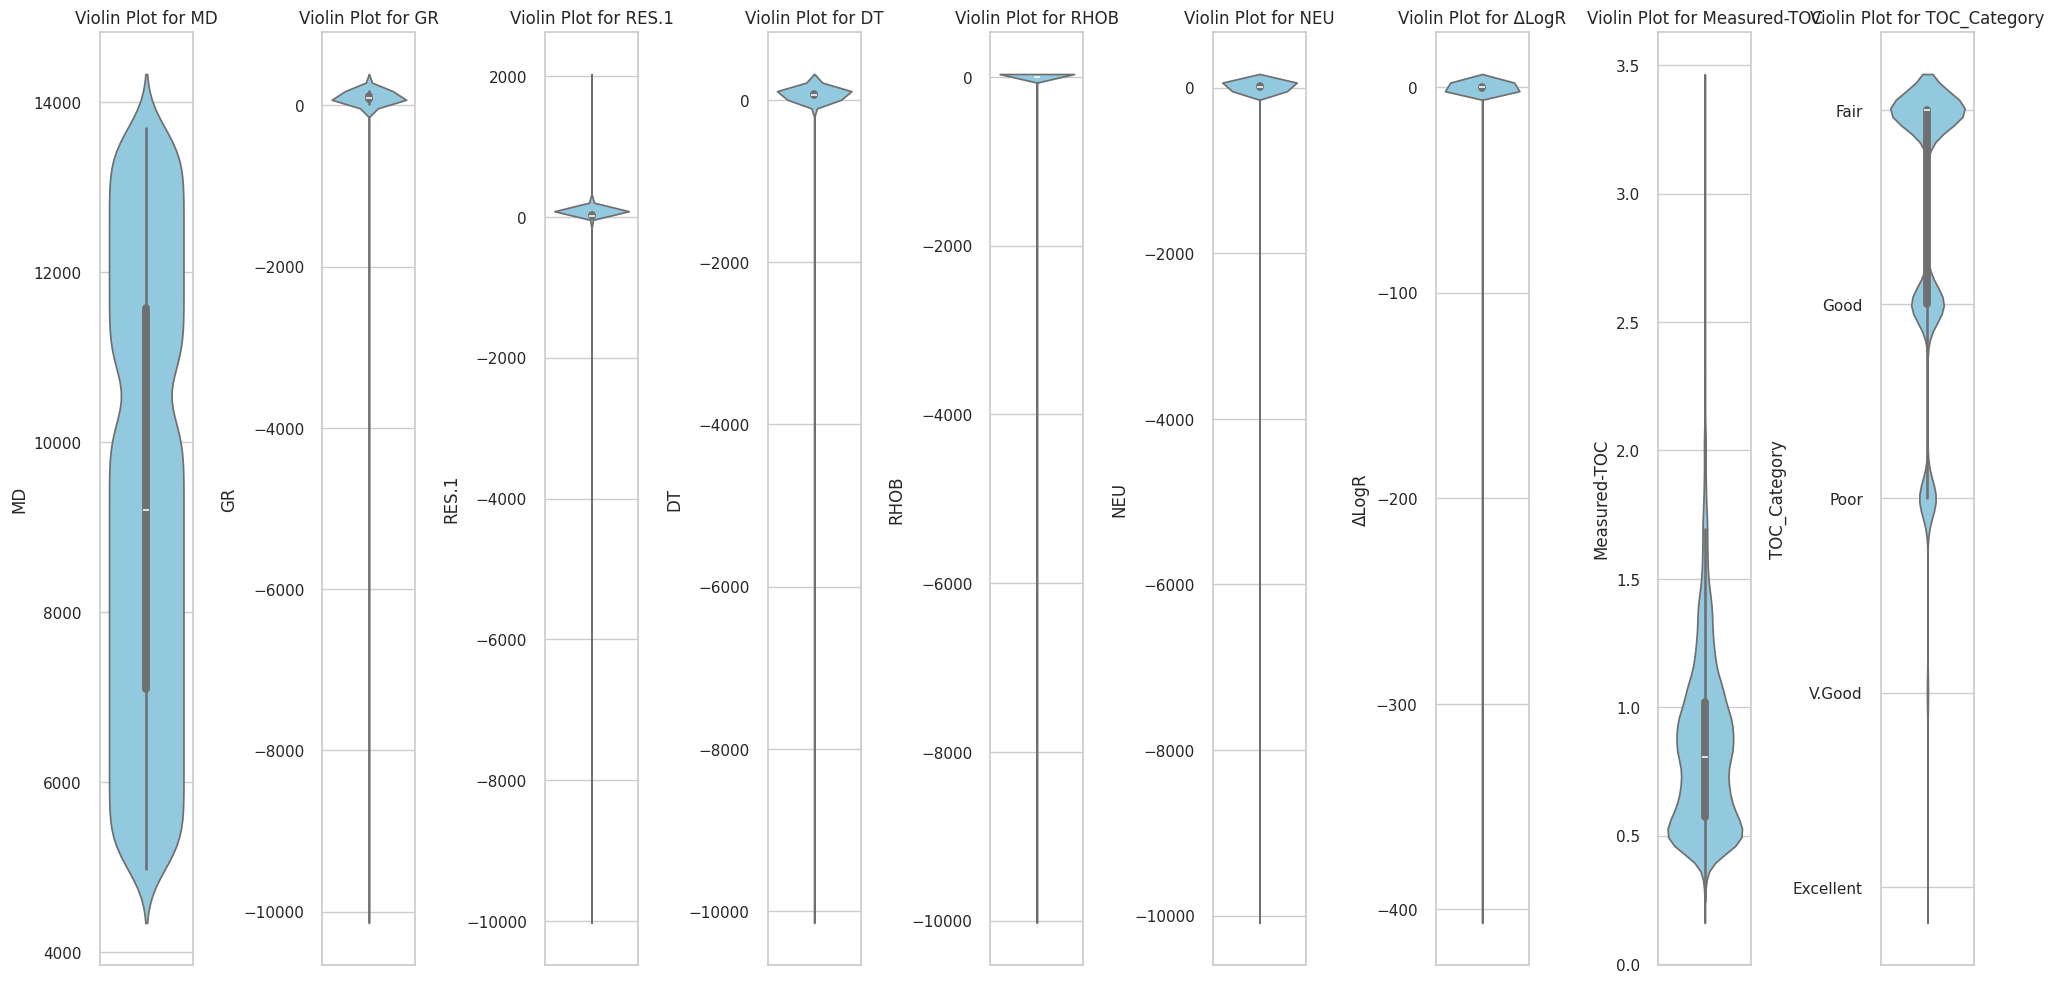

In [5]:
# Create a violin plot for each column in the DataFrame
import seaborn as sns
violin_plot_all_columns(toc_estm_df)

In [6]:
toc_estm_df.head()

,MD,GR,RES.1,DT,RHOB,NEU,ΔLogR,Measured-TOC,TOC_Category
0,4978.00,40.4902,1970.836,56.5478,1.6991,51.6765,1.556562,0.8686,Fair
1,4978.25,40.3001,1968.455,56.0224,1.7037,53.4121,1.535021,0.8669,Fair
2,4978.50,38.8794,1966.763,56.0224,1.7081,50.7708,1.534648,0.8652,Fair
3,4978.75,37.9678,1966.763,55.3079,1.7130,57.6586,1.506068,0.8635,Fair
4,4979.00,37.4406,1962.986,55.3079,1.7149,59.4048,1.505233,0.8618,Fair


In [7]:
toc_estm_df=toc_estm_df[['MD', 'GR', 'RES.1', 'DT', 'RHOB', 'NEU', 'ΔLogR','TOC_Category']]

In [8]:
import numpy as np
df=toc_estm_df.copy()
df=df.dropna()

# Separate features and target
X = df.drop('TOC_Category', axis=1)
y = df['TOC_Category']

In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable y
y_encoded = label_encoder.fit_transform(y)

# Now y_encoded contains the encoded values of y


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

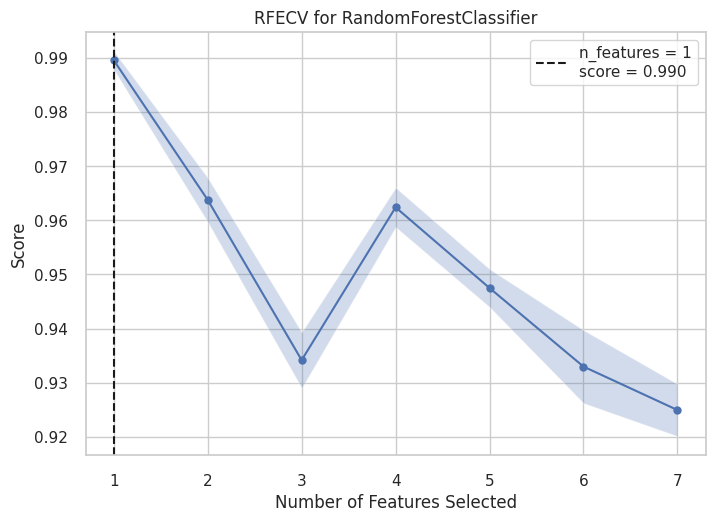

Selected Features Indices: [0]
Time taken: 644.8510103225708 seconds


In [11]:
import time

# Record the start time
start_time = time.time()

cv = StratifiedKFold(5)
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring='accuracy')

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()

# Access the selected features
selected_features = visualizer.support_

# Print the indices of selected features
print("Selected Features Indices:", [i for i, selected in enumerate(selected_features) if selected])


# Record the end time
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

# Print the time taken
print(f"Time taken: {time_taken} seconds")

In [12]:
pip install pycaret

In [13]:
import pandas as pd
from pycaret.classification import *
clf = setup(toc_estm_df, target='TOC_Category')


,Description,Value
0,Session id,3005
1,Target,TOC_Category
2,Target type,Multiclass
3,Target mapping,"Excellent: 0, Fair: 1, Good: 2, Poor: 3, V.Good: 4"
4,Original data shape,"(33823, 8)"
5,Transformed data shape,"(33823, 8)"
6,Transformed train set shape,"(23676, 8)"
7,Transformed test set shape,"(10147, 8)"
8,Numeric features,7
9,Rows with missing values,25.8%


In [15]:
best_model = compare_models(exclude=['AUC'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9678,0.0000,0.9678,0.9677,0.9677,0.9421,0.9421,0.2850
knn,K Neighbors Classifier,0.9437,0.0000,0.9437,0.9438,0.9437,0.8990,0.8990,0.2620
et,Extra Trees Classifier,0.9389,0.0000,0.9389,0.9395,0.9380,0.8877,0.8890,2.8580
rf,Random Forest Classifier,0.9346,0.0000,0.9346,0.9354,0.9336,0.8795,0.8811,5.7320
xgboost,Extreme Gradient Boosting,0.8996,0.0000,0.8996,0.8992,0.8987,0.8166,0.8173,1.4520
gbc,Gradient Boosting Classifier,0.8711,0.0000,0.8711,0.8742,0.8672,0.7559,0.7626,29.0020
lightgbm,Light Gradient Boosting Machine,0.7494,0.0000,0.7494,0.7510,0.7495,0.5468,0.5471,4.5040
ridge,Ridge Classifier,0.5981,0.0000,0.5981,0.3577,0.4477,-0.0001,-0.0010,0.1110
dummy,Dummy Classifier,0.5981,0.0000,0.5981,0.3577,0.4477,0.0000,0.0000,0.1200
lda,Linear Discriminant Analysis,0.5978,0.0000,0.5978,0.3577,0.4476,-0.0004,-0.0053,0.1120


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [17]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…